In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import itertools
from tqdm import tqdm, trange

from agents.dqn import DoubleDQNAgent, QNetwork
from env import GridEnvDeform, POMDPWrapper_v0, create_maze
import matplotlib.pyplot as plt



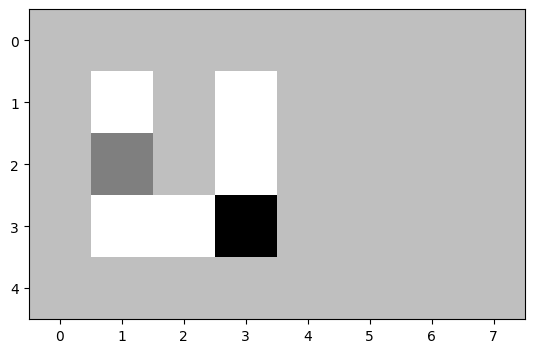

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")

T = torch.load(f"models/T_maze_{N}.pt", weights_only=True)
R = torch.load(f"models/R_maze_{N}.pt", weights_only=True)
O = torch.load(f"models/O_maze_{N}.pt", weights_only=True)


# fully observable train

notice that the train is fully observable, in the following cell each transition is \
(1) the current state \
(2) the action taken \
(3) the reward received \
(4) the next state \
(5) the done flag

where current state is an int (range(0, len(states)))

# tabular q-learning

In [104]:
# from agents.tabular_qlearning import q_learning

# Q = q_learning(env, 20000, 0.1, 0.95, 0.5, states_dict=state_dict)

# np.save(f"agents/tabularQ_maze_{N}_20k.npy", Q)

Q = np.load(f"agents/tabularQ_maze_{N}.npy")

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -6.88996568,  -7.99817568,  -9.06731416,
        -14.26667888, -13.55522795, -11.29367114,   0.        ],
       [  0.        ,  -5.82295409,  -3.51197801, -10.24467562,
        -14.94129718, -13.6366324 , -12.39203609,   0.        ],
       [  0.        ,  -4.92616118,   0.990713  ,   3.66767523,
        -13.63890276, -13.51963595, -11.13700941,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

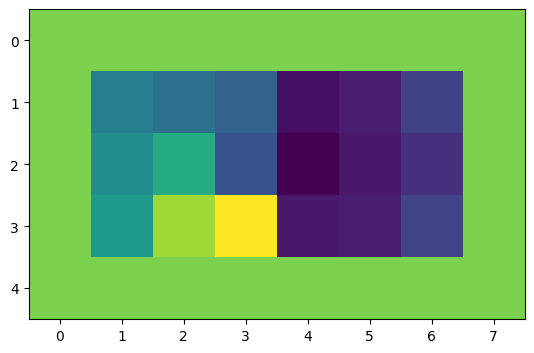

In [107]:
# state_value = torch.zeros(lenS)
# for s in range(lenS):
#     state_value[s] = np.max(Q[s])

state_value = np.max(Q,axis=1)


Value_matrix_plot = np.zeros(env.maze.shape)
for s, state in enumerate(states):
    # print(f"State: {state}, Value: {state_value[s]}")
    if state[1] == (1,1) and state[0][2] == 3:
        Value_matrix_plot[state[0][0],state[0][1]] = state_value[s]

# plot the value function as matrix
plt.imshow(Value_matrix_plot)
Value_matrix_plot


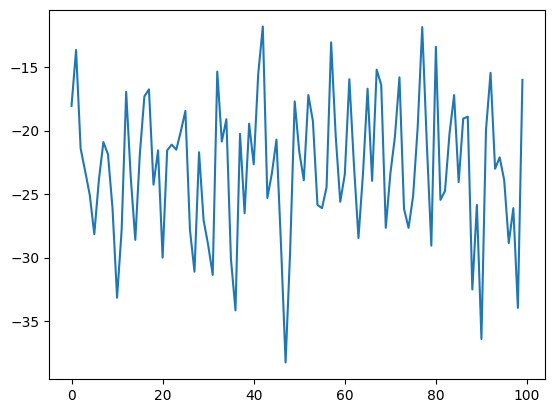

In [18]:
def eval_tabular(env : GridEnvDeform, Q, num_episodes=100):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = state_dict[s]

        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = np.argmax(Q[state])
            next_state, reward, done, _, info = env.step(action.item(),s)
            state = state_dict[next_state]

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [eval_tabular(env, Q, 10) for _ in range(100)]   
plt.plot(rewards)

In [19]:
eval_tabular(env, Q, 1000)

np.float64(-24.0825)

## train Q network to approximate the tabular Q function

In [20]:
model = QNetwork(5, 4)
epochs = 100
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.MSELoss()


Q = torch.tensor(Q,dtype=torch.float32)

# train the model
for epoch in range(epochs):
    for s, y in zip(states, Q[:]):
        x = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}')    


Epoch 0 loss: 185.56707763671875
Epoch 5 loss: 486.8017578125
Epoch 10 loss: 294.8102111816406
Epoch 15 loss: 210.0247802734375
Epoch 20 loss: 181.28836059570312
Epoch 25 loss: 119.79946899414062
Epoch 30 loss: 49.84914779663086
Epoch 35 loss: 14.198976516723633
Epoch 40 loss: 9.045607566833496
Epoch 45 loss: 3.172901153564453
Epoch 50 loss: 2.154345989227295
Epoch 55 loss: 3.4595398902893066
Epoch 60 loss: 7.925548076629639
Epoch 65 loss: 2.6286258697509766
Epoch 70 loss: 1.1319931745529175
Epoch 75 loss: 0.9698816537857056
Epoch 80 loss: 1.0777568817138672
Epoch 85 loss: 0.6157218217849731
Epoch 90 loss: 0.5555011034011841
Epoch 95 loss: 0.517115592956543


array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,  -41.83639908,  -38.21925354,  -70.23751831,
        -114.67685699, -139.72169495, -139.77618408,    0.        ],
       [   0.        ,  -34.22377777,  -31.56644821,  -20.35635567,
         -91.56660461, -132.07568359, -139.4546814 ,    0.        ],
       [   0.        ,  -41.82218552,  -36.46925354,  -10.14715385,
         -20.01251602, -124.27709198, -138.9757843 ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ]])

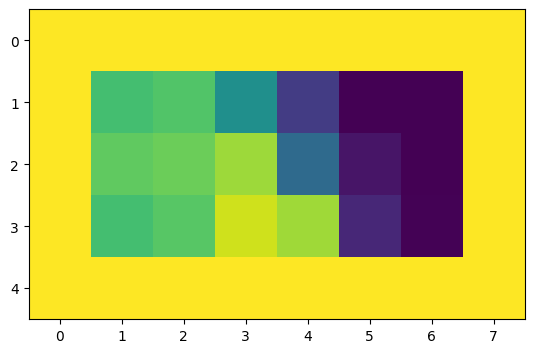

In [95]:
state_value = torch.zeros(lenS)
for s in range(lenS):
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(model(state))


Value_matrix_plot = np.zeros(env.maze.shape)
for s, state in enumerate(states):
    # set orientation of the agent to 3 to get the value of the state s = (x,y,3)
    # expected xy0 xy1 xy2 xy3 are the same
    if state[1] == (1,1) and state[0][2] == 0:
        Value_matrix_plot[state[0][0],state[0][1]] = state_value[s]

plt.imshow(Value_matrix_plot)
Value_matrix_plot


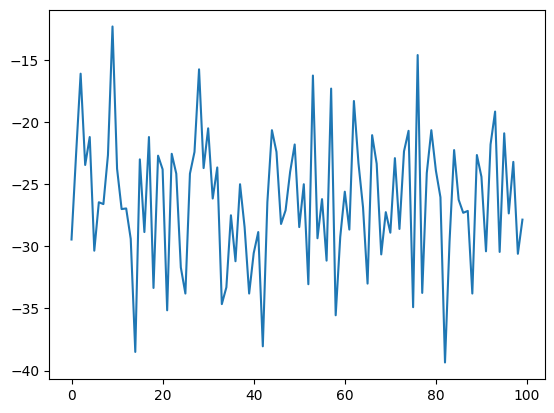

In [23]:
def evaluate_network(env : GridEnvDeform, model, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = torch.argmax(model(state))
            next_state, reward, done, _, info = env.step(action.item(),s)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)


            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [evaluate_network(env, model, 10) for _ in range(100)]
plt.plot(rewards)


In [25]:
evaluate_network(env, model, 1000)

np.float64(-25.742)

# train dqn 
optionally start with a pretrained model 

In [26]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(state)
            next_state, reward, done, _, info = env.step(action,s)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)


            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward


In [27]:
state_dim = 5
action_dim = 4

agent = DoubleDQNAgent(state_dim, action_dim, lr = 0.01, q_network=model)

env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)

In [28]:
num_episodes = 500

rewards = []
evalrewards = []

for episode in trange(num_episodes):
    #
    #state, _ = env_wrapper.reset()
    
    # when bypassing the wrapper, we need to convert the state to the actual state
    s, _ = env.reset()
    state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done:
        action = agent.choose_action(state)
        
        # obs, reward, done, info = env_wrapper.step(state, action)
        # next_state = info['actual_state']
        # agent.store_transition([state], action, reward, [next_state], done)
        
        # bypassing the wrapper to get the actual state should be equilvalent to the above
        # remember to reset the environment with the actual state and not the wrapper 
        s_ , reward, done , _, _ = env.step(action,s, execute=True)
        next_state = torch.tensor([item for sublist in s_ for item in sublist], dtype=torch.float32)
        agent.store_transition(state, action, reward, next_state, done)

        agent.train()
        state = next_state
        episode_reward += reward
        steps += 1        
        if done or steps > 200:
            agent.update_epsilon()
            rewards.append(episode_reward)
            # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.2f}")
            break
    
    if episode != 0 and episode % 5 == 0:
        avg_reward = evaluate_agent_training(env, agent)
        evalrewards.append(avg_reward)
        # print(f"Episode {episode + 1}/{num_episodes}, Average Reward: {avg_reward}")

print("Training complete.")
print("evalrewards: ", evalrewards)

100%|██████████| 500/500 [03:16<00:00,  2.55it/s]

Training complete.
evalrewards:  [np.float64(-22.95), np.float64(-35.6), np.float64(-28.7), np.float64(-33.55), np.float64(-23.6), np.float64(-26.5), np.float64(-26.8), np.float64(-30.0), np.float64(-36.85), np.float64(-25.1), np.float64(-34.9), np.float64(-22.4), np.float64(-27.5), np.float64(-32.7), np.float64(-19.15), np.float64(-22.6), np.float64(-19.35), np.float64(-22.55), np.float64(-37.5), np.float64(-36.8), np.float64(-29.2), np.float64(-29.35), np.float64(-21.6), np.float64(-27.55), np.float64(-41.2), np.float64(-38.2), np.float64(-20.85), np.float64(-26.1), np.float64(-22.7), np.float64(-23.1), np.float64(-23.0), np.float64(-29.55), np.float64(-26.5), np.float64(-31.75), np.float64(-18.75), np.float64(-21.9), np.float64(-25.8), np.float64(-27.5), np.float64(-14.7), np.float64(-14.85), np.float64(-33.2), np.float64(-26.1), np.float64(-26.15), np.float64(-28.2), np.float64(-24.25), np.float64(-18.6), np.float64(-25.4), np.float64(-32.95), np.float64(-41.15), np.float64(-26.85)

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,  -52.51133728,  -43.89691544,  -77.77895355,
        -114.38848877, -139.22596741, -139.33714294,    0.        ],
       [   0.        ,  -47.37731934,  -43.20346832,  -70.23970032,
        -114.88907623, -140.88044739, -139.54962158,    0.        ],
       [   0.        ,  -39.8009491 ,  -35.52407837,   43.95208359,
        -113.55614471, -141.05392456, -139.72311401,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ]])

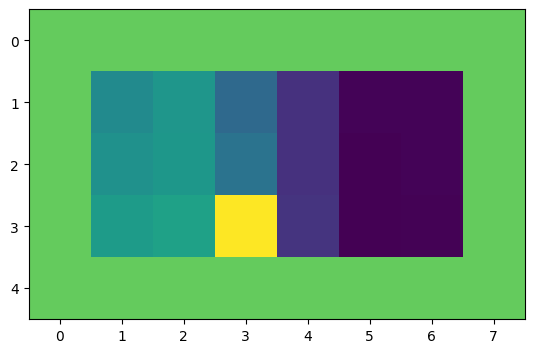

In [102]:
# attenzione il valore dello stato è il valore xyphi quindi per ogni posizione ho 4 valori 
# (mi aspetto che il valore sia lo stesso per tutte le orientazioni)
state_value = torch.zeros(lenS)
for s in range(lenS):
    # set orientation to 0
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(agent.q_network(state))


Value_matrix_plot = np.zeros(env.maze.shape)
for s, state in enumerate(states):
    # print(f"State: {state}, Value: {state_value[s]}")
    if state[1] == (1,1) and state[0][2] == 2:
        Value_matrix_plot[state[0][0],state[0][1]] = state_value[s]

plt.imshow(Value_matrix_plot)
Value_matrix_plot

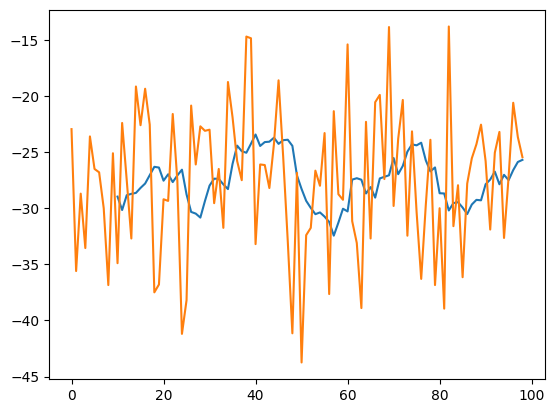

In [30]:
# plot evalrewards
rolling = [-np.inf for _ in range(10)] + [np.mean(evalrewards[i-10:i]) for i in range(10,len(evalrewards))]
plt.plot(rolling)
plt.plot(evalrewards)

In [32]:
evaluate_agent_training(env, agent, 1000)

np.float64(-25.961)

# rendered evaluation


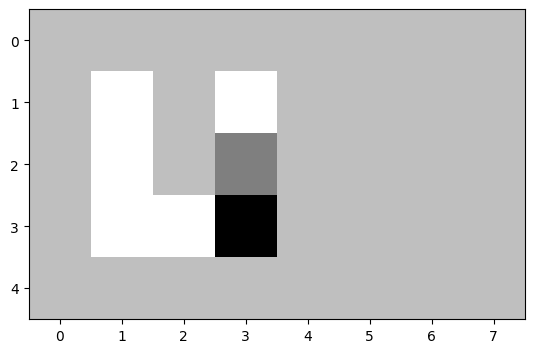

state:  tensor([2., 3., 0., 1., 1.])
best action:  0


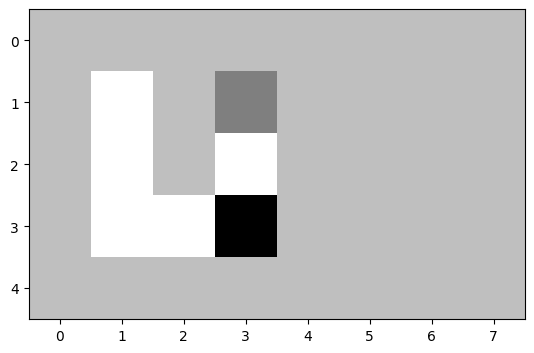

state:  tensor([1., 3., 0., 1., 1.])
best action:  3


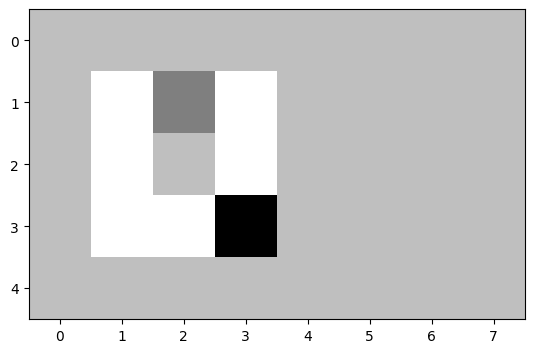

state:  tensor([1., 2., 3., 1., 1.])
best action:  3


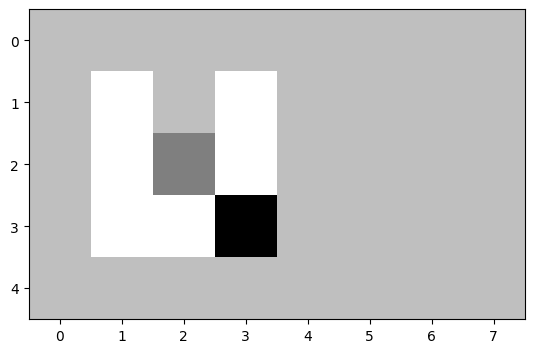

state:  tensor([2., 2., 2., 1., 1.])
best action:  0


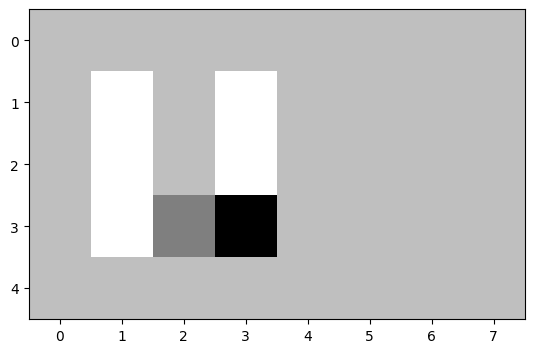

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


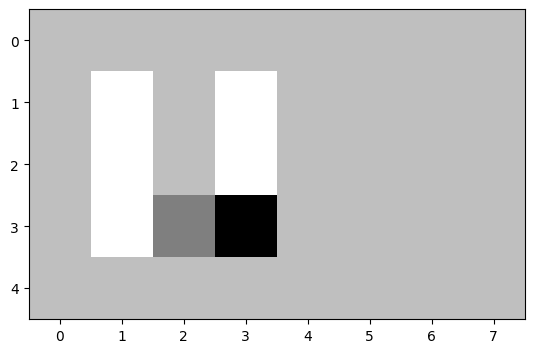

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


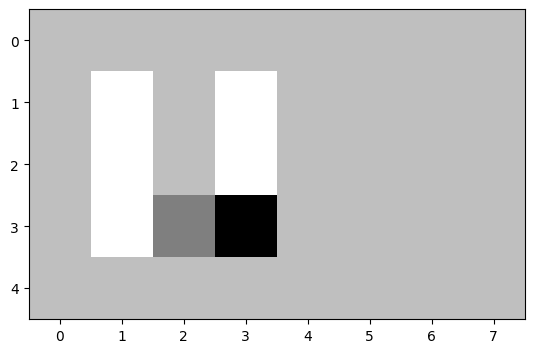

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


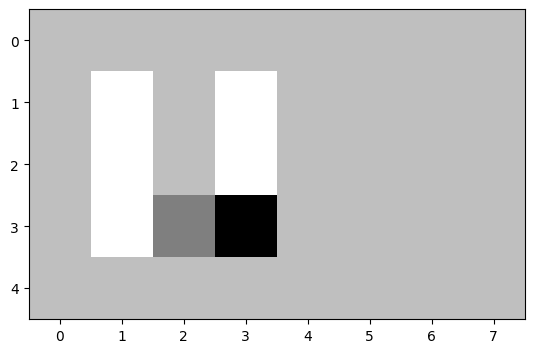

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


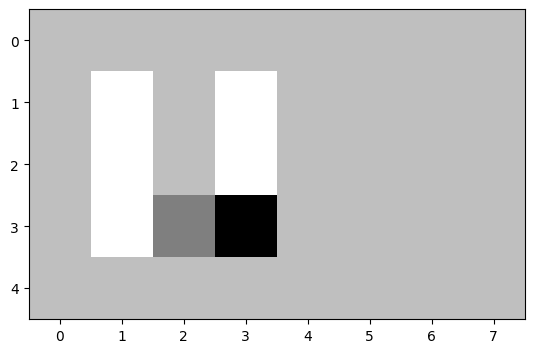

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


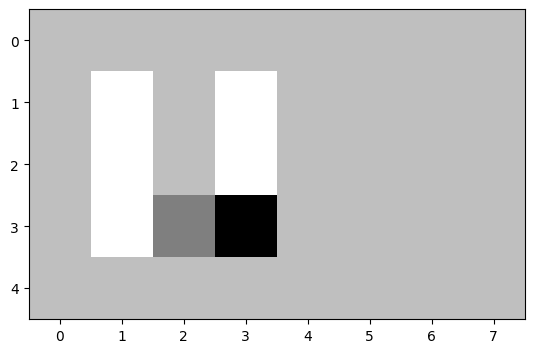

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


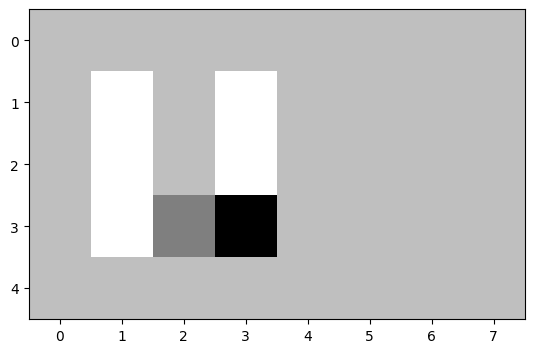

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


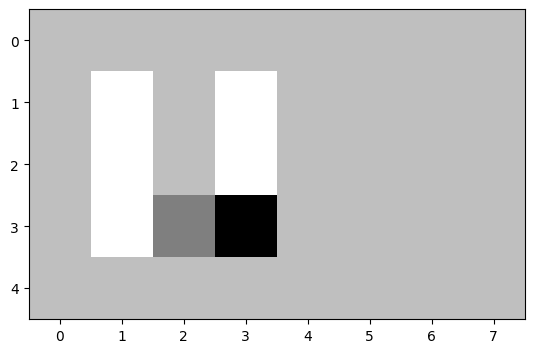

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


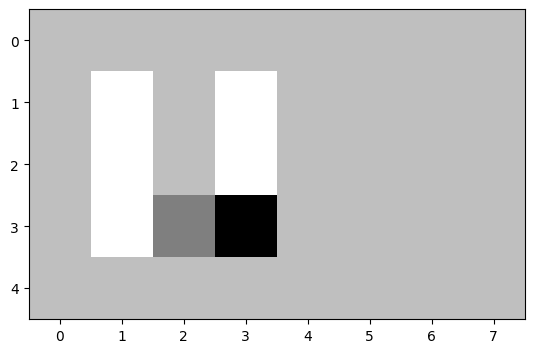

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


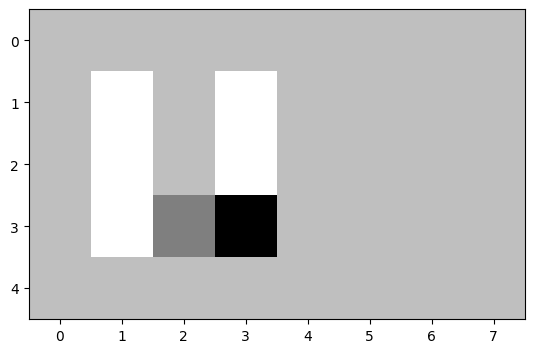

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


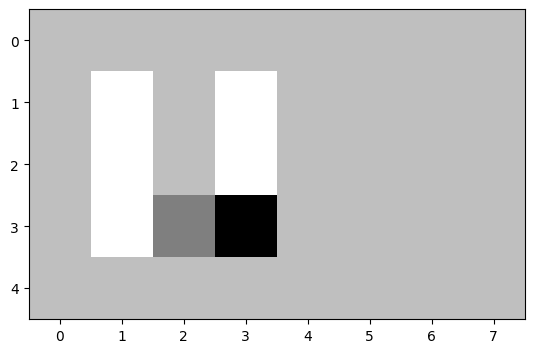

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


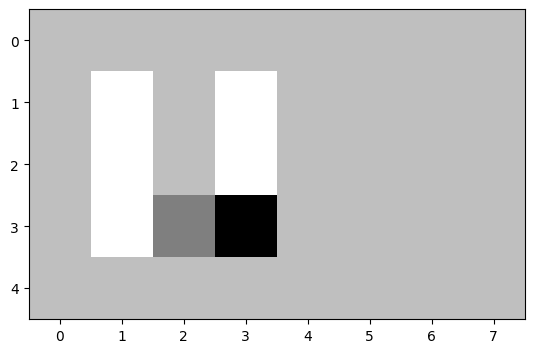

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


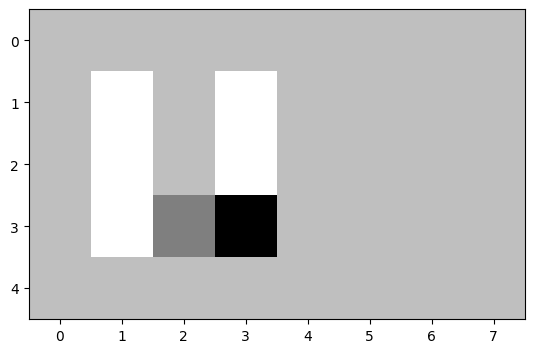

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


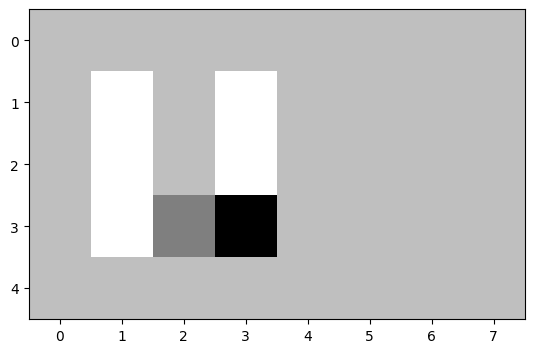

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


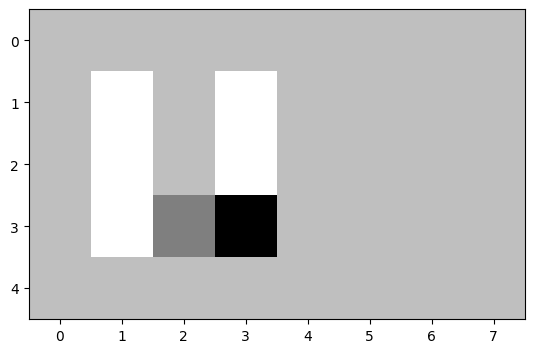

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


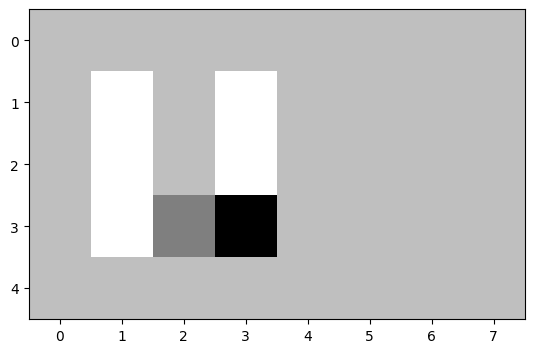

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


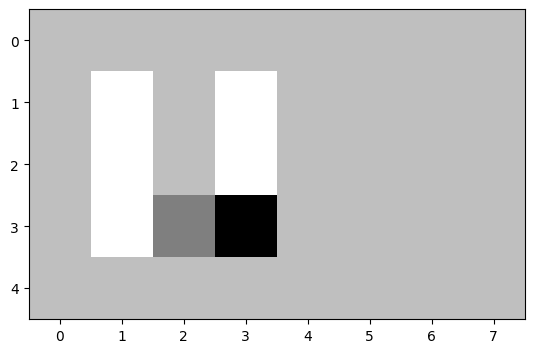

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


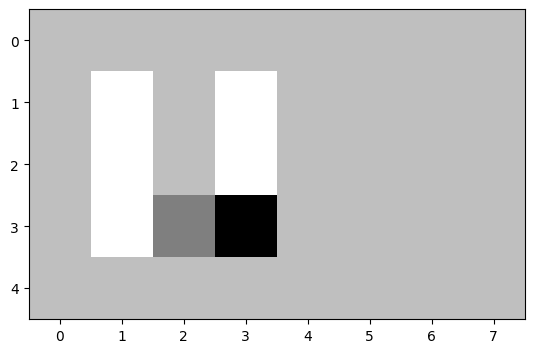

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


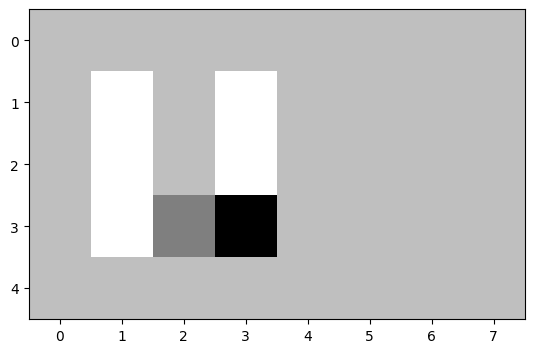

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


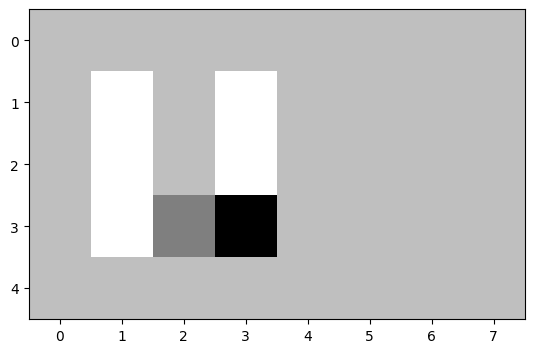

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


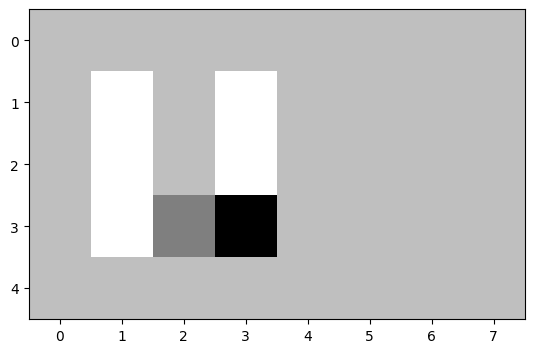

state:  tensor([3., 2., 2., 1., 1.])
best action:  0


np.float64(-26.0)

In [54]:
import time 

def evaluate_agent(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        # env.render()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            env.render()
            print("state: ", state)

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(state)
            print("best action: ", action)
            next_state, reward, done, _, info = env.step(action, execute=True)
            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)


            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
            time.sleep(0.1)
            
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

evaluate_agent(env, agent, 1)


# transition check

In [9]:
# copy what is done in training:
# start from a random state chose an action and store the transition 
state, _ = env_wrapper.reset()
action = agent.choose_action([state])

obs, reward, done, info = env_wrapper.step(state, action)
next_state = info['actual_state'] # next true state (not observation or belief)

agent.store_transition([state], action, reward, [next_state], done)
state, action, reward, next_state, done


(109, 0, -1.0, 109, False)

In [41]:
state = ((1., 6., 0.),(1., 1.))
action = 3

In [43]:
state_dict[state]

40

In [45]:
state = 40

In [50]:
next_state = ((1., 5., 3.),(1., 1.))
next_state = state_dict[next_state]

((1, 6, 0), (1, 1))


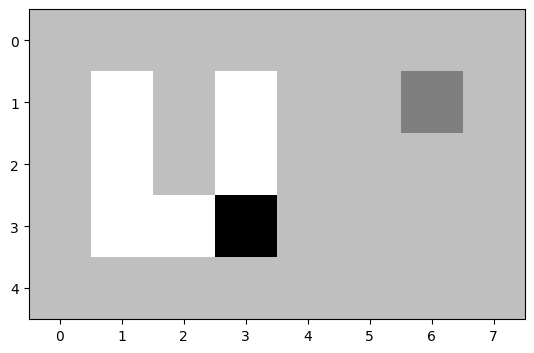

(((1, 5, 3), (1, 1)), -2, np.False_, False, {})


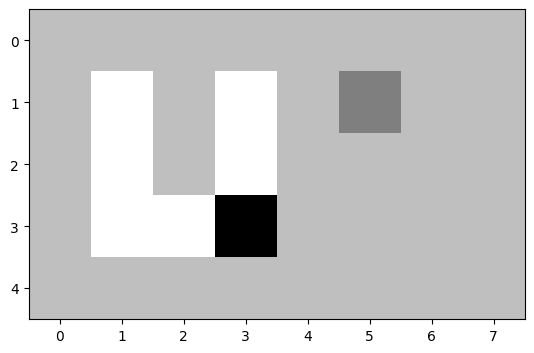

Training transition is correct


In [52]:
# set state and render
env.set_state(states[state])
print(states[state])
env.render()

# step and render
print(env.step(action, states[state], execute=True))
env.render()

# check if the transition is correct
assert env.get_state() == states[next_state]
print("Training transition is", "correct" if env.get_state() == states[next_state] else "incorrect")

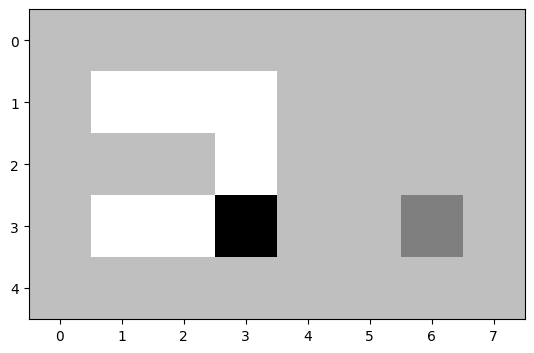

In [23]:
maze = create_maze(N)
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()